In [2]:
import os
import torch
import numpy as np

import matplotlib.pyplot as plt
from model import Generator
from util import *

plt.rcParams['figure.dpi'] = 150

## Generator를 선언한다.
- eval().to(device)와 to(device).eval()의 차이가 뭘까?

In [3]:
device = 'cuda' #@param ['cuda', 'cpu']

generator1 = Generator(256, 512, 8, channel_multiplier=2).eval().to(device)
generator2 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()
generator3 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()
generator4 = Generator(256, 512, 8, channel_multiplier=2).to(device).eval()

## 각 모델을 로드한다.

In [4]:
mean_latent1 = load_model(generator1, './models/face-pt.pt')
mean_latent2 = load_model(generator2, './models/disney-pt.pt')
mean_latent3 = load_model(generator3, './models/disney2000.pt')
mean_latent4 = load_model(generator4, './models/disney10000.pt')

In [5]:
print(len(mean_latent1))
print(mean_latent1[0].shape)

20
torch.Size([1, 512])


mean_latent는 평균적인 latent vector값을 리턴해 주는 것 같은데.. 그 값이 중요한 것이 아니고..
latent vector의 생김새를 알 수 있다는 점에서 참고할만 함. 나중에 projector.py 에서 읽어 들여 사용할 때 참고할만 함.
아무튼, latent vector는 1x512 로 이루어진 텐서 20개로 이루어진 리스트이다. 기억하자!

In [6]:
truncation = .5 # 잘림?
face_seed =  44654 #@param {type:"number"}  # 임의의 랜덤값. 숫자 아무거나 막 박아도 됨.
disney_seed =  686868 #@param {type:"number"} 

## 각 학습모델을 이용해 이미지를 생성해 본다.

<class 'list'>
20
<class 'torch.Tensor'>
torch.Size([1, 512])


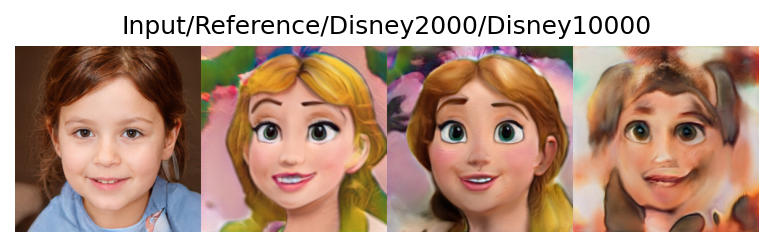

In [7]:
with torch.no_grad():
    # torch에 수동으로 random seed를 지정한다.
    torch.manual_seed(face_seed)
    
    # torch에서 난수를 생성한다.
    source_code = torch.randn([1, 512]).to(device)
    
    # face.pt에서 임의의 난수에 맵핑되는 latent vector를 만들어 온다. 
    #  - truncation
    #  - mean_latent는 모델 로드할때 가져온 값인데... 뭘까 궁금해지네.
    latent1 = generator1.get_latent(source_code, truncation=truncation, mean_latent=mean_latent1)
    print(type(latent1))
    print(len(latent1))
    print(type(latent1[0]))
    print(latent1[0].shape)
    
    # 이미지를 생성한다.
    source_im, _ = generator1(latent1)

    # 같은 작업을 disney.pt에 대해 수행하여, 디즈니 캐릭터 이미지 아무거나 하나 만들어 온다.
    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent2 = generator2.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent2)
    reference_im, _ = generator2(latent2)

    # 같은 작업을 내가 학습시킨 disney2000.pt에 대해 수행하여, 디즈니 캐릭터 이미지 아무거나 하나 만들어 온다.
    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent3 = generator3.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent3)
    reference_im2000, _ = generator3(latent3)

    # 같은 작업을 내가 학습시킨 disney10000.pt에 대해 수행하여, 디즈니 캐릭터 이미지 아무거나 하나 만들어 온다.
    torch.manual_seed(disney_seed)
    reference_code = torch.randn([1, 512]).to(device)
    latent4 = generator4.get_latent(reference_code, truncation=truncation, mean_latent=mean_latent4)
    reference_im10000, _ = generator4(latent4)    
    
    # 네 이미지를 한번에 보여준다.
    display_image(torch.cat([source_im, reference_im, reference_im2000, reference_im10000], -1), 
                  size=None, title='Input/Reference/Disney2000/Disney10000')

음... 그렇다면,... 10000번을 학습시킨 모델은 답이 아니란 말이네.. 한 500번 돌린것으로 한것 같은데?
불행히도 학습할 때 2000번마다 저장하도록 해서 제일 낮은 녀석이 2000밖에 남아 있지 않았음.

## 자, 이제 사진을 디즈니 스타일로 바꿔 보자

뭔가 서로 막 섞어주고 이것저것 해 주는데, 왜 이렇게 하는 것인지에 대해서는 잘 모르겠다.
논문을 읽어봐야 알라나..


In [8]:
num_swap =  6  # 숫자가 클 수록 원래 사진 이미지에 가깝다. 작을수록 디즈니 이미지에 가깝고
alpha =  0.5   # 숫자가 클수록 괴랄해진다. 작을수록 원래 사진 이미지로 가고..

early_alpha = 0

def toonify(_from, _to, _fromgen, _togen):
    with torch.no_grad():
        noise1 = [getattr(_fromgen.noises, f'noise_{i}') for i in range(_fromgen.num_layers)]
        noise2 = [getattr(_togen.noises, f'noise_{i}') for i in range(_togen.num_layers)]

        out1 = _fromgen.input(_from[0])
        out2 = _togen.input(_to[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        out1, _ = _fromgen.conv1(out, _from[0], noise=noise1[0])
        out2, _ = _togen.conv1(out, _to[0], noise=noise2[0])
        out = (1-early_alpha)*out1 + early_alpha*out2

        skip1 = _fromgen.to_rgb1(out, _from[1])
        skip2 = _togen.to_rgb1(out, _to[1])
        skip = (1-early_alpha)*skip1 + early_alpha*skip2

        i = 2
        for conv1_1, conv1_2, noise1_1, noise1_2, to_rgb1, conv2_1, conv2_2, noise2_1, noise2_2, to_rgb2 in zip(
            _fromgen.convs[::2], _fromgen.convs[1::2], noise1[1::2], noise1[2::2], _fromgen.to_rgbs,
            _togen.convs[::2], _togen.convs[1::2], noise2[1::2], noise2[2::2], _togen.to_rgbs
        ):


            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_1(out, _from[i], noise=noise1_1)
            out2, _ = conv2_1(out, _to[i], noise=noise2_1)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            out1, _ = conv1_2(out, _from[i], noise=noise1_2)
            out2, _ = conv2_2(out, _to[i], noise=noise2_2)
            out = (1-conv_alpha)*out1 + conv_alpha*out2
            i += 1

            conv_alpha = early_alpha if i < num_swap else alpha
            skip1 = to_rgb1(out, _from[i], skip)
            skip2 = to_rgb2(out, _to[i], skip)
            skip = (1-conv_alpha)*skip1 + conv_alpha*skip2

            i += 1

    image = skip.clamp(-1,1)
    
    return image



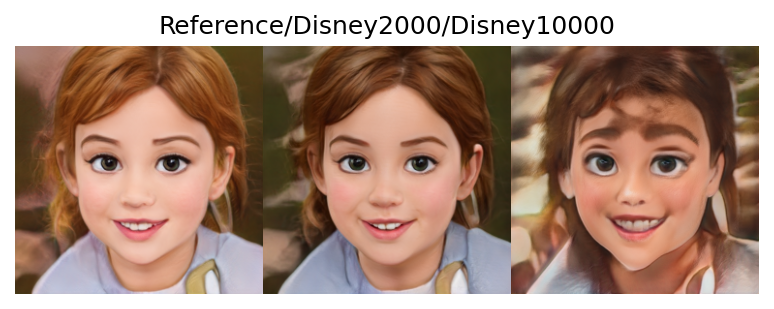

In [9]:
result1 = toonify(latent1, latent2, generator1, generator2)
result2 = toonify(latent1, latent3, generator1, generator3)
result3 = toonify(latent1, latent4, generator1, generator4)

# 네 이미지를 한번에 보여준다.
display_image(torch.cat([result1, result2, result3], -1), 
            size=None, title='Reference/Disney2000/Disney10000')

음.. 과도한 학습이 괴물을 만들었군..
2000번 돌린 것이 가장 나아 보이는데?

## 이번에는 일반 사진을 가져다가 디즈니풍으로 바꽈보자

일반 사진을 바로 사용할 수는 없고, face.pt의 latent space에서 이 사진이 가장 유사하다고 판단되는 지점의 latent vector를 찾아와야 한다. 



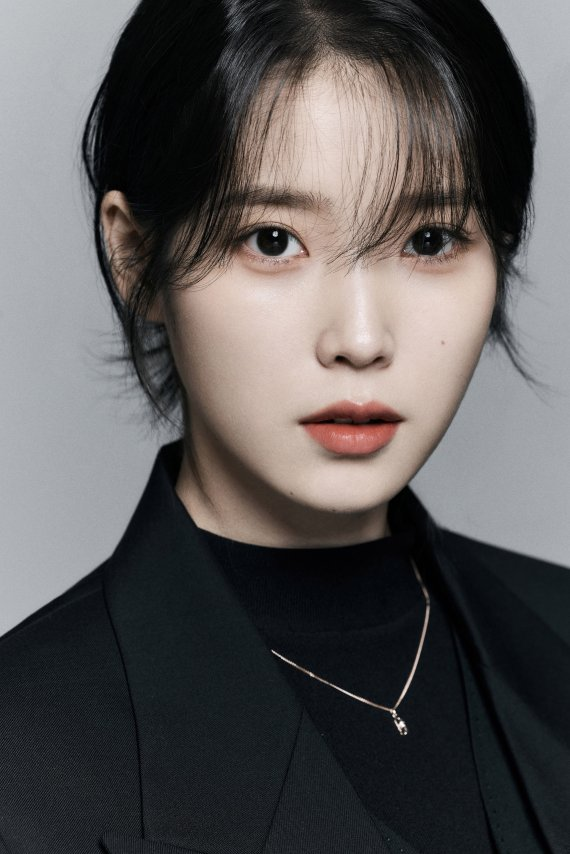

In [10]:
from PIL import Image

Image.open('iu.jpg')

못 생겼지만 이쁜 아이유로 가자궁!!

다만, 이 이미지를 바로 쓸 수는 없으니 이리저리 짜개고 쪼개고 하자고.. 구찮지만..

In [38]:
latent_real = torch.load('./inversion_codes/iu.pt')['latent']
print(type(latent_real))
print(latent_real.shape)
print(latent_real.size(0))

<class 'torch.Tensor'>
torch.Size([8704])
8704


In [39]:
latent_real= latent_real.unsqueeze(0)

In [30]:
print(type(latent_real))
print(latent_real.shape)
print(latent_real.size(0))

<class 'torch.Tensor'>
torch.Size([1, 8704])
1


In [31]:
print(latent_real.ndim)

2


In [40]:
latent_real = style2list(latent_real)

torch.load로 읽어오면 연속적인 Tensor 값만 죽 읽어온다. 얘를 1x512 형태의 Tensor 20개로 이뤄진 리스트로 변환해 줘야 한다. 그 역할을 style2list가 해 줘야 하는데...에러가 난다.

근데 1x512 형태의 Tensor 20개가 아니라..

style2list_len = [512, 512, 512, 512, 512, 512, 512, 512, 512, 512,
                  512, 512, 512, 512, 512, 256, 256, 256, 128, 128]

요렇게 생겼다.

이 값들을 다 더하면 8704가 나온다.

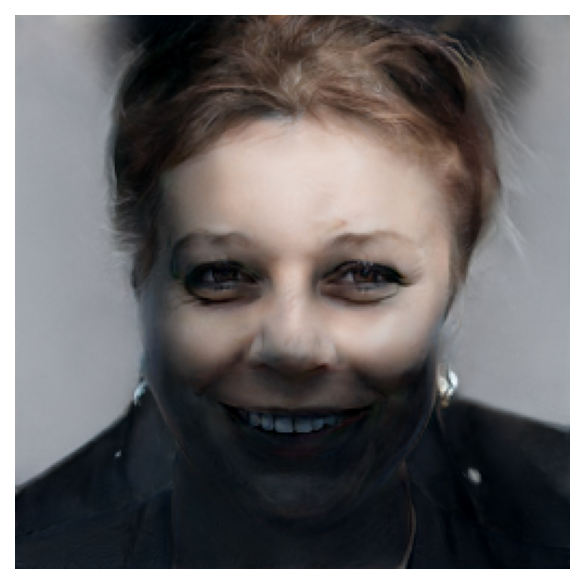

In [41]:
source_im, _ = generator1(latent_real)

display_image(source_im)

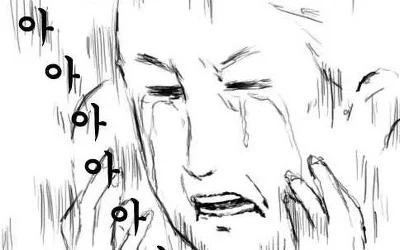

## 홀리.. 쉿.. 

누가 우리 아이유를 이따구로 만들랬어. 양놈들 학습모델의 한계인가!!!!

빵형의 카리나는 이러지 않았는데...


여보게. 남궁형. 

이건 아니지 않은가?

이 이미지로 더 진행해 봐야.. 의미가 없겠군... 싶으나 그래도 여기까지 왔는데.. 함 돌려는 주자.

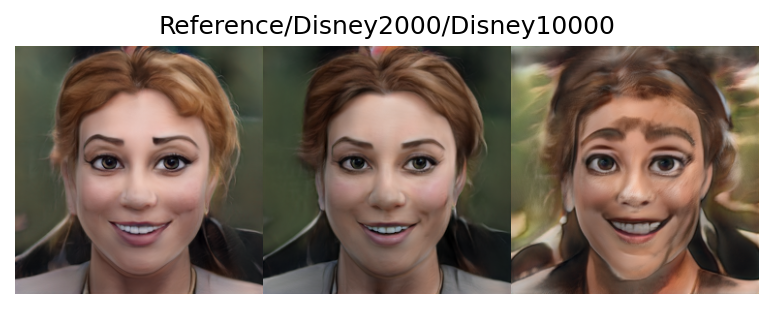

In [42]:
result1 = toonify(latent_real, latent2, generator1, generator2)
result2 = toonify(latent_real, latent3, generator1, generator3)
result3 = toonify(latent_real, latent4, generator1, generator4)

# 네 이미지를 한번에 보여준다.
display_image(torch.cat([result1, result2, result3], -1), 
            size=None, title='Reference/Disney2000/Disney10000')

좀 나아지긴 했다만.... 1만번 학습 시킨 모델은 뭐냐... 좀 사이키한데..